In [45]:
import math
import numpy as np
from sympy.physics.wigner import wigner_3j
import matplotlib.pyplot as plt

## 3rd Order Nonlinear Susceptibility

The formula to calculate the 3rd order nonlinear susceptibility:


#### Equation 1
$$
\chi^{(3)}(3\omega)=\sum_{kmn}\frac{(ea_0)^4}{3(\hbar c)^3}(\mu_{0k}\mu_{km}\mu_{mn}\mu_{n0})  \times \Bigg( \frac{1}{(\omega-\omega_{0k})(2\omega-\omega_{0n})}\Big(\frac{1}{3\omega-\omega_{0m}} -
	\frac{1}{\omega-\omega_{m0}}\Big)-\frac{1}{(\omega-\omega_{k0})(2\omega-\omega_{n0})}\Big(\frac{1}{3\omega-\omega_{m0}}-\frac{1}{\omega-\omega_{0m}}\Big)\Bigg) 
$$

where $\omega$ is the frequency of the incoming photon, and $\omega$s with subscripts represent the various transitions.  Their units are in $cm^{-1}$

It is important to note that each $\omega$ term should also have a $\Gamma$ term which is imaginary.  This term corresponds to the amount of time the electron stays in this state before decaying.  This term is only important for wavelengths close to resonance.  Although we are close to resonance, we do not need to factor this in.  

In [46]:
'''
converts wavelength (10^-9 m) into a frequency (cm^-1)
'''
def lambda_omega(lda):
    return 10**7/lda

In [47]:
'''
This function corresponds to equation 1.  No imaginary terms are added, and the opposing subscripts of a frequency
is treated as the negative.
'''

def omegaterms(omega, o_k,o_m,o_n):
    p1=((omega+o_k)*(2*omega+o_n))**(-1)*((3*omega+o_m)**(-1)-(omega-o_m)**(-1))
    p2=((omega-o_k)*(2*omega-o_n))**(-1)*((3*omega-o_m)**(-1)-(omega+o_m)**(-1))
    return p1-p2

### Wigner 3j Symbol and Racah Formula

To determine the dipole transition moment, we use the Wigner-Eckart Theorem to split the operation.

$$
<j_mm_m|\vec{\mu}|j_nm_n>=<j_mm_m10|j_nm_n><j_m||\mu||j_n>
$$

The first term can be converted to the Wigner 3j symbol:

#### Equation 2

$$
<j_mm_m10|j_nm_n>=(-1)^{j_m-m_m}
\begin{pmatrix}
    j_m&1&j_n\\
    -m_m&0&m_n
\end{pmatrix}
$$

The 'matrix' can then be solved using the Racah Formula:

#### Equation 3

$$
\begin{pmatrix}
    j_m&1&j_n\\
    m_m&0&m_n
\end{pmatrix}
=(-1)^{j_m-1-m_n}\sqrt{\Delta j_m1j_n}\sqrt{(j_m \pm m_m)!(j_n\pm m_n)!}\times \sum_t\frac{(-1)^t}{x}
$$

The $\Delta j_m1j_n$ is a triangle coefficient. 

#### Equation 3.1

$$
\Delta j_m1j_n=\frac{(j_m+1-j_n)!(j_m-1+j_n)!(-j_m+1+j_n)!}{(j_m+j_n+2)!}
$$


#### Equation 3.2

$$
x=t!(j_n-1+t+j_m)!(j_n-j_m+t+1)!(j_m+1-j_n-t)!(j_m-1-m_m)!(j_n-1+m_n)!
$$

$$
t \quad \epsilon \quad [j_m \pm m_m,1,1,j_n \pm m_n,j_m+1-j_n,1+j_n-j_m,j_m+j_n-1]
$$

Although I originally made a function to calculate this value, it gave me some errors. I later found a built-in function in Python that would give me the Wigner 3j symbol, so I just used that.

### Reduced Matrix Element

This is the second term that we get from the Wigner Eckart Theorem.  This term is independent of the orientation of the total angular momentum, so there are less calculations to do.  However, we can equate this reduced matrix element to the line strength ($S_{ab}$), oscillator strength ($f_{ab}$), and transition probability ($A_{ab}$).

$$
|<a||\mu||b>|^2=S_{ab}
$$

#### Equation 4

$$
A_{ab}=\frac{2\pi e^2}{m_ec\epsilon_0\lambda^2}\frac{g_a}{g_b}f_{ab}=\frac{16\pi^3}{3h\epsilon_0\lambda^3g_a}S_{ab}
$$

The transition probabilities along with the corresponding energies were given by NIST, so the reduced matrix element can be calculated.

In [48]:
'''
Importing or providing all the necessary information
'''
m_e = 9.1094e-31     # Mass of electron in kg,
h = 6.6261e-34  # Planck's constant in J*s"
e = 1.6022e-19     # Electron charge in C"
a_0= 5.3e-11     #Bohr radius in m"
eps_0=8.85*10**(-12)    #epsilon naught value C^2/N m^2

'''
Energy levels are loaded from a csv. Data is from NIST Atomic Spectra Database.  There are 2 columns.  The first
column corresponds to the energy level, and the second column is the total angular momentum.
'''
E_levels=np.loadtxt('/home/kait/Documents/TRIUMF/energylevels_j.csv' ,dtype='float,int', delimiter=',',usecols=(0,1),unpack=True)


'''
Energy Differences (first column, cm^-1), Transition Ps (second col,10**8 s^-1), and wavelengths (3rd col,nm).  
Data is from NIST Atomic Spectra Database.
'''
transitions=np.loadtxt('/home/kait/Documents/TRIUMF/transition_probs.csv',dtype='float,float,float', delimiter=',',usecols=(0,1,2),unpack=True)

In [49]:
"""
This function is used to calculate the reduced matrix element using equation 4 
"""
def rme(E1,j1,E2,j2):
    #find the absolute value of the difference in energy levels, and round to the fourth digit
    dE=round(abs(E1-E2),4)
    
    #go to transition table and see if it is there. If it is, get the transition probability and wavelength
    if dE in transitions[0]:
        index=list(transitions[0]).index(dE)
        A12=transitions[1][index]
        wavelength=transitions[2][index]*10 #converts nm to m
    else:
        return 0
    
    #equation 4
    #S=3*h*A12*10**8*eps_0*wavelength**3*(2*j2+1)/(16*math.pi**3)
    S=(wavelength**3*(2*j1+1)*A12*10**8)/(2.0261*10**18)
    return np.sqrt(S) #/(e*a_0) #converts C*m to units e*a_0

In [50]:
'''
Calculates dipole transition moments which is the product of the reduced matrix element, Wigner 3j symbol, and
(-1)^(j-mj). In the function, E is the energy level, j is the total angular momentum, and mj is the orientation. 
The total is the running total of the RMEs and Wigner 3j symbols.  This is needed because the end is the product
of 4 transition dipole moments together.  The count is which transition dipole moment we are dealing with.  The 
array keeps track of the specific energy levels, and the total for each path.

The count first starts at 0, and goes through all the energy levels.  The energy starts at ground state, and 
iterates through all the energy levels to see which combination has a nonzero reduced matrix element.  For all
nonzero matrix elements, the Wigner 3j value is found by iterating through all the orientations (mjs). 
If there is a nonzero mj value, the total is multiplied by the RME and Wigner3j symbol, and the function is called
again. However, the starting energy level is now shifted to the transitioned energy level we found before,
and the count is 3

When 3 dipole transition moments have been calculated, the fourth one is guaranteed to transition to the ground 
state. The (-1)^(j-mj) term is multiplied here, and the whole value is added to the array.  The array with all the
transitioning energy levels, and value of the 4 transition dipole moments is appended to an external array.  The
final result will be in the 'mus' array, and will be a list of lists.  Each list has 3 integers to correspond to 
the energy levels it is transitioning to, and the last element is the product of the 4 transition dipole moments.
'''

def mu(E,j, mj,total,count,array):
    
    #indicates the last transition which has to transition back to ground state
    if count==3:
        #calculates the last transition moment to the ground state as well as multiplies the (-1)^(j-mj) term
        total*=rme(E,j,0,0)*wigner_3j(j,1,0,mj,0,0)*(-1)**(j-mj)
        
        #appends this array to an external array
        mus.append(array+[total])
        return     
    
    #loops through all energy levels
    for i in range(len(E_levels[0])):
        #calculate the rme value for each energy level, and ignores if zero
        rme_val=rme(E,j,E_levels[0][i],E_levels[1][i])
        if rme_val==0:
            continue
        else:
            #loops through all the orientations of the transitioning energy level
            for k in range(-E_levels[1][i],E_levels[1][i]+1):
                #calculate the rme value for each energy level, and ignores if zero
                wigner3j_val=wigner_3j(j,1,E_levels[1][i],mj,0,k)
                if wigner3j_val==0:
                    continue
                else:
                    #nonzero value multiplies products to total, and calls function w the second level as the 
                    #level you are starting from
                    total*=rme_val*wigner3j_val*(-1)**(j-mj)
                    mu(E_levels[0][i],E_levels[1][i],k,total,count+1,array+[i])


In [51]:
mus=[]
#finds all energy levels, and dipole transition moments needed
mu(0,0,0,1,0,[])

'''
The goal of the function is to multiply the omega terms with the dipole moments for each path, and add them
together. This function is then called to find the nonlinear susceptibilities for a range of 330 to 400 nm.
'''

def chi(p):
    result=0
    for ind in mus:
        o_k=E_levels[0][ind[0]]
        o_n=E_levels[0][ind[1]]
        o_m=E_levels[0][ind[2]]
        
        #all different paths are added together
        result+=abs(ind[3]*omegaterms(p, o_k,o_m,o_n))
    return result


xvalues=np.arange(25000,30000,25)
yvalues=[]
xlambdas=[]
for i in range(len(xvalues)):
    #xvalues[i]=lambda_omega(xvalues[i])
    yvalues.append(chi(xvalues[i]))

(2e-13, 7e-13)

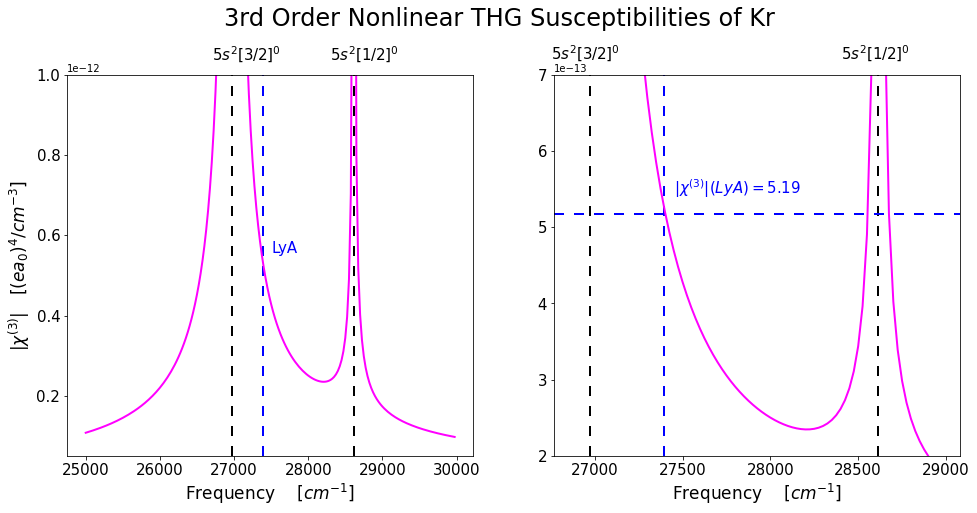

In [54]:
'''
Plotting Function
'''

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('3rd Order Nonlinear THG Susceptibilities of Kr',fontsize=24, y=1.015)
fig.set_figheight(7)
fig.set_figwidth(16)

plt.xticks(fontsize= 15)
plt.yticks(fontsize= 15)
plt.axvline(x=80916.7685/3,
                     color         = 'black', 
                     marker        = 's',
                     markersize    = 0,
                     linestyle     = 'dashed',
                     dashes        = (5, 5),
                     linewidth     = 2)
plt.axvline(x=85846.7051/3,
                     color         = 'black', 
                     marker        = 's',
                     markersize    = 0,
                     linestyle     = 'dashed',
                     dashes        = (5, 5),
                     linewidth     = 2)
plt.axvline(x=27397.26,
                     color         = 'blue', 
                     marker        = 's',
                     markersize    = 0,
                     linestyle     = 'dashed',
                     dashes        = (5, 5),
                     linewidth     = 2)
plt.text(27450, 10.52**(-12), '$|\chi^{(3)}|(LyA)=5.19$',fontsize=15,color='blue')
plt.axhline(y=5.17*10**(-13),
                     color         = 'blue', 
                     marker        = 's',
                     markersize    = 0,
                     linestyle     = 'dashed',
                     dashes        = (5, 5),
                     linewidth     = 2)
plt.text(28400, 7.2*10**(-13), '$5s^2[1/2]^0$',fontsize=15)
plt.text(26750, 7.2*10**(-13), '$5s^2[3/2]^0$',fontsize=15)

plt.sca(ax1)
plt.xticks(fontsize= 15)
plt.yticks(fontsize= 15)
plt.axvline(x=80916.7685/3,
                     color         = 'black', 
                     marker        = 's',
                     markersize    = 0,
                     linestyle     = 'dashed',
                     dashes        = (5, 5),
                     linewidth     = 2)
plt.axvline(x=85846.7051/3,
                     color         = 'black', 
                     marker        = 's',
                     markersize    = 0,
                     linestyle     = 'dashed',
                     dashes        = (5, 5),
                     linewidth     = 2)
plt.axvline(x=27397.26,
                     color         = 'blue', 
                     marker        = 's',
                     markersize    = 0,
                     linestyle     = 'dashed',
                     dashes        = (5, 5),
                     linewidth     = 2)
plt.text(28300, 9.97**(-12), '$5s^2[1/2]^0$',fontsize=15)
plt.text(26700, 9.97**(-12), '$5s^2[3/2]^0$',fontsize=15)
plt.text(27500, 10.5**(-12), 'LyA',fontsize=15,color='blue')

ax1.plot(xvalues,yvalues,
                     color         = 'magenta', 
                     marker        = 's',
                     markersize    = 0, 
                     linewidth     = 2,)
ax1.set_xlabel('Frequency $ \quad [cm^{-1}]$',fontsize=17)  
ax1.set_ylim(.5*10**(-13),10*10**(-13))
ax1.set_ylabel('$|\chi^{(3)}| \quad [(ea_0)^4/cm^{-3}]$',fontsize=17)


ax2.plot(xvalues[75:160],yvalues[75:160],
                     color         = 'magenta', 
                     marker        = 's',
                     markersize    = 0, 
                     linewidth     = 2,)
ax2.set_xlabel('Frequency $ \quad [cm^{-1}]$',fontsize=17)
ax2.set_ylim(2*10**(-13),7*10**(-13))

In [55]:
fig.savefig('/home/kait/Documents/TRIUMF/THF_chis.png',bbox_inches='tight')

In [56]:
5.19*10**(-13)*(e*a_0)**4/(3*(h*3*10**8)**3*(1.24*10**(-19)))

9.235429217523111e-37

In [57]:
def omegaterms(omega, o_k,o_m,o_n):
    p1=((o_k)*(omega+o_n))**(-1)*((2*omega+o_m)**(-1)-(-o_m)**(-1))
    p2=((-o_k)*(omega-o_n))**(-1)*((2*omega-o_m)**(-1)-(o_m)**(-1))
    return p1-p2

xvalues=np.arange(210,270,.1)
yvalues=[]
for i in range(len(xvalues)):
    xvalues[i]=lambda_omega(xvalues[i])
    yvalues.append(chi(xvalues[i]))

(1e-13, 3.5e-13)

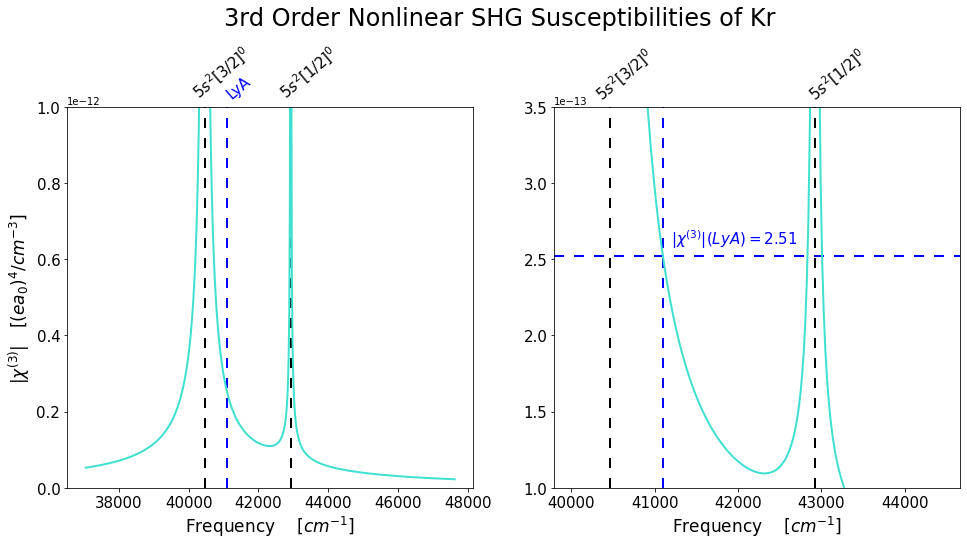

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('3rd Order Nonlinear SHG Susceptibilities of Kr',fontsize=24, y=1.08)
fig.set_figheight(7)
fig.set_figwidth(16)

plt.xticks(fontsize= 15)
plt.yticks(fontsize= 15)
plt.axvline(x=80916.7685/2,
                     color         = 'black', 
                     marker        = 's',
                     markersize    = 0,
                     linestyle     = 'dashed',
                     dashes        = (5, 5),
                     linewidth     = 2)
plt.axvline(x=85846.7051/2,
                     color         = 'black', 
                     marker        = 's',
                     markersize    = 0,
                     linestyle     = 'dashed',
                     dashes        = (5, 5),
                     linewidth     = 2)
plt.axvline(x=41095.5,
                     color         = 'blue', 
                     marker        = 's',
                     markersize    = 0,
                     linestyle     = 'dashed',
                     dashes        = (5, 5),
                     linewidth     = 2)
plt.axhline(y=2.52*10**(-13),
                     color         = 'blue', 
                     marker        = 's',
                     markersize    = 0,
                     linestyle     = 'dashed',
                     dashes        = (5, 5),
                     linewidth     = 2)
plt.text(42800,3.55*10**(-13), '$5s^{ 2}[1/2]^0$',fontsize=15,rotation=40)
plt.text(40250, 3.55*10**(-13), '$5s^2[3/2]^0$',fontsize=15,rotation=40)
plt.text(41200, 2.6*10**(-13), '$|\chi^{(3)}|(LyA)=2.51$',fontsize=15,color='blue')

plt.sca(ax1)
plt.xticks(fontsize= 15)
plt.yticks(fontsize= 15)
plt.axvline(x=80916.7685/2,
                     color         = 'black', 
                     marker        = 's',
                     markersize    = 0,
                     linestyle     = 'dashed',
                     dashes        = (5, 5),
                     linewidth     = 2)
plt.axvline(x=85846.7051/2,
                     color         = 'black', 
                     marker        = 's',
                     markersize    = 0,
                     linestyle     = 'dashed',
                     dashes        = (5, 5),
                     linewidth     = 2)
plt.axvline(x=41095.5,
                     color         = 'blue', 
                     marker        = 's',
                     markersize    = 0,
                     linestyle     = 'dashed',
                     dashes        = (5, 5),
                     linewidth     = 2)
plt.text(42500, 9.98**(-12), '$5s^{ 2}[1/2]^0$',fontsize=15,rotation=40)
plt.text(40000, 9.98**(-12), '$5s^2[3/2]^0$',fontsize=15,rotation=40)
plt.text(41000, 9.98**(-12), 'LyA',fontsize=15,color='blue',rotation=40)



ax1.plot(xvalues,yvalues,
                     color         = 'turquoise', 
                     marker        = 's',
                     markersize    = 0, 
                     linewidth     = 2,)
ax1.set_xlabel('Frequency $ \quad [cm^{-1}]$',fontsize=17)  
ax1.set_ylim(0,10**(-12))
ax1.set_ylabel('$|\chi^{(3)}| \quad [(ea_0)^4/cm^{-3}]$',fontsize=17)


ax2.plot(xvalues[150:400],yvalues[150:400],
                     color         = 'turquoise', 
                     marker        = 's',
                     markersize    = 0, 
                     linewidth     = 2,)
ax2.set_xlabel('Frequency $ \quad [cm^{-1}]$',fontsize=17)
ax2.set_ylim(10**(-13),3.5*10**(-13))

In [59]:
2.51*10**(-13)*(e*a_0)**4/(3*(h*3*10**8)**3*(1.24*10**(-19)))

4.46645998766532e-37

In [60]:
fig.savefig('/home/kait/Documents/TRIUMF/EFISHG_chi.png',bbox_inches='tight')

In [10]:
mus

[[1, 7, 1, 0.780739272806658],
 [1, 9, 1, -0.0895809861844914*sqrt(30)],
 [1, 11, 1, 0.0323027451947329],
 [1, 11, 3, 0.0138452599819437*sqrt(30)],
 [3, 11, 1, -0.018984634955891*sqrt(3)],
 [3, 11, 3, -0.0244109785445851*sqrt(10)]]